In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simps

%matplotlib inline

Подгружаем данные

In [2]:
df = pd.read_csv('data\ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', sep='\t',comment='#')
df.columns = ['Temp', 'Time', 'DSC', 'Sence']

df.head()

,Temp,Time,DSC,Sence
0,20.01794,0.01,0.022839,3.36733
1,20.01857,0.02,0.022820,3.36733
2,20.02401,0.03,0.022770,3.36734
3,20.03631,0.04,0.022824,3.36735
4,20.05572,0.05,0.023849,3.36737


Text(0.5, 1.0, 'Raw cure kinetics signal by temperature')

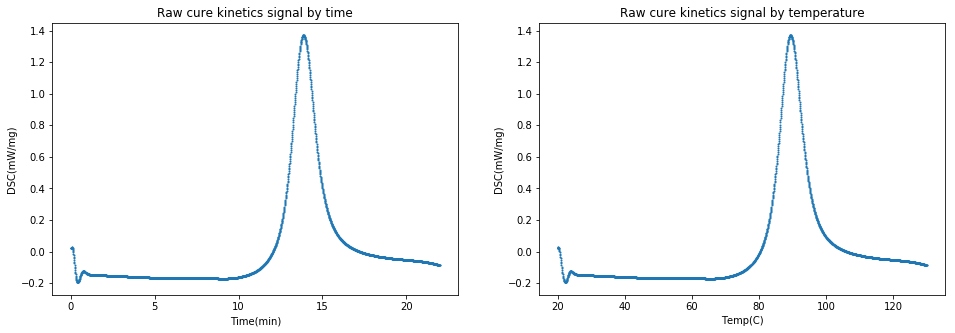

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].plot(df['Time'], df['DSC'], "o", markersize=1)
ax[0].set_title('Raw cure kinetics signal by time')

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1)
ax[1].set_title('Raw cure kinetics signal by temperature')

### Тут ищем точки начала и конца реакции

Давай по искать точки начала и конца пика по температуре - так будет удобнее. На этом графике он будет где-то от 60 до 110. Вообще отделюную часть кода нужно уделить определению точек начала и конца. Я пытался сделать это автоматически красиво, но получилось так себе. Наверное лучше составить отдельную таблицу и захардкодить.

[0.27778, 0.28154]


Text(0.5, 1.0, 'Raw cure kinetics signal by temperature')

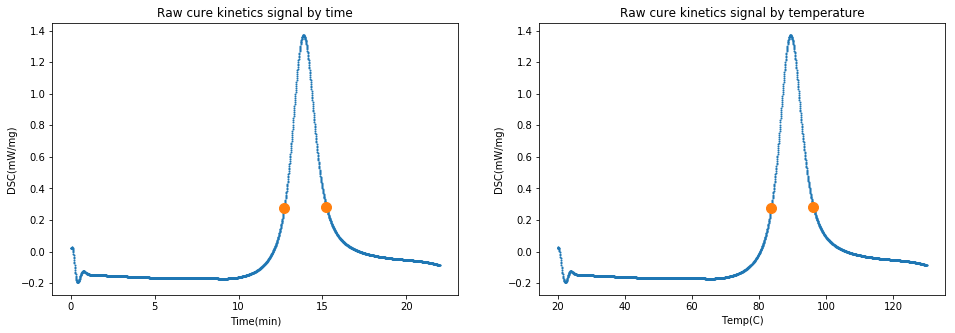

In [4]:
peaks_positive, _ = find_peaks(df['DSC'], height=1.2)
peaks_width, width_heights, _, _ = peak_widths(df['DSC'], peaks_positive, rel_height = 0.75)

peak_start = df['DSC'][df['DSC']>0.27737123].first_valid_index()
peak_end = df['DSC'][df['DSC']>0.27737123].last_valid_index()


print([df['DSC'][peak_start],df['DSC'][peak_end]])

fig, ax = plt.subplots(1, 2, figsize = (16, 5))


ax[0].plot(df['Time'], df['DSC'], "o", markersize=1, label = "Signal")
ax[0].plot([df['Time'][peak_start],df['Time'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
              "o", markersize=10, label = "Baseline")
ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Raw cure kinetics signal by time')

ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1, label = "Signal")
ax[1].plot([df['Temp'][peak_start],df['Temp'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
                "o", markersize=10, label = "Baseline")
ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Raw cure kinetics signal by temperature')

#TODO add legend on plots

Строим бейслайн по точкам начала и конца, режем пик, приводим к бейслайну

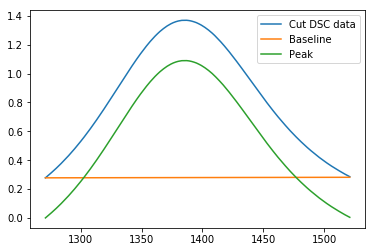

In [5]:
baseline = np.zeros(0)

for i in range(peak_end - peak_start):  # строим baseline
    new_val = (df['DSC'][peak_end] - df['DSC'][peak_start])/(peak_end - peak_start)*i + df['DSC'][peak_start]
    baseline = np.append(baseline,new_val)

peak = df['DSC'][peak_start: peak_end] - baseline
    
plt.plot(df['DSC'][peak_start: peak_end], label = "Cut DSC data")
plt.plot(range(peak_start, peak_end), baseline, label = "Baseline")
plt.plot(range(peak_start, peak_end), peak, label = "Peak")
plt.legend()

По приведенному к бейслайну пику строим альфу - степень полимеризации

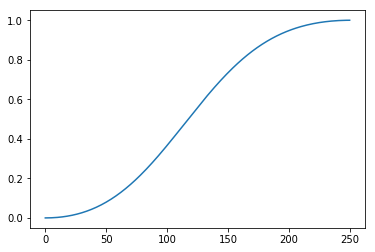

In [6]:
spent_energy = simps(peak)
alpha = []
    
for i,_ in enumerate(peak):
    alpha.append(simps(peak[:i+1])/spent_energy)
plt.plot(alpha)

Наверное тут стоит начать создавать датафрейм, где будет только только пик + добавить к нему колонку альфы и $\frac{d\alpha}{dt}$